In [1]:
from utils import get_seg_image_at_volume
import SimpleITK as sitk
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib import cm
from sklearn.metrics import average_precision_score

In [2]:
def plot_seg(background: np.array, seg: np.array, cut_coords: tuple, axs=None, color='g', label=''):
    if axs is None:
        fig, axs = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)
        #fig.patch.set_facecolor('black')
        axs[0].imshow(background[
            cut_coords[0]-50:cut_coords[0]+50,
            cut_coords[1]-50:cut_coords[1]+50, 
            cut_coords[2]], cmap='gray')
        axs[0].axvline(x=50,color='white', linestyle=':')
        axs[0].axhline(y=50,color='white', linestyle=':')
        axs[0].invert_yaxis()
        axs[1].imshow(background[
            cut_coords[0]-50:cut_coords[0]+50,
            cut_coords[1],
            cut_coords[2]-50:cut_coords[2]+50], cmap='gray')
        axs[1].axvline(x=50,color='white', linestyle=':')
        axs[1].axhline(y=50,color='white', linestyle=':')
        axs[1].invert_yaxis()
        
    axs[0].contour(seg[
            cut_coords[0]-50:cut_coords[0]+50,
            cut_coords[1]-50:cut_coords[1]+50, 
            cut_coords[2]], colors=color, levels=[0.5], linewidths=2)
    axs[1].contour(seg[
            cut_coords[0]-50:cut_coords[0]+50,
            cut_coords[1],
            cut_coords[2]-50:cut_coords[2]+50], colors=color, levels=[0.5], linewidths=2)
    
    for a in axs:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.set_yticks([])
        a.set_xticks([])
        a.set_aspect('equal')

    plt.subplots_adjust(wspace=0, hspace=0)
        
    return axs

/tmp/ipykernel_2678188/260456243.py:37: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0, hspace=0)


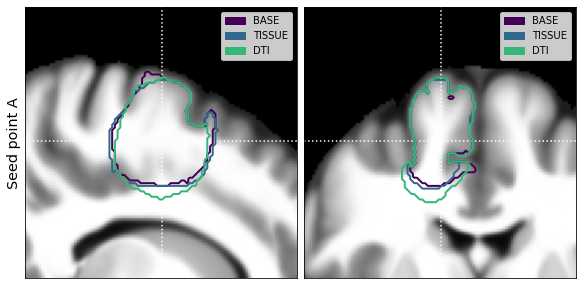

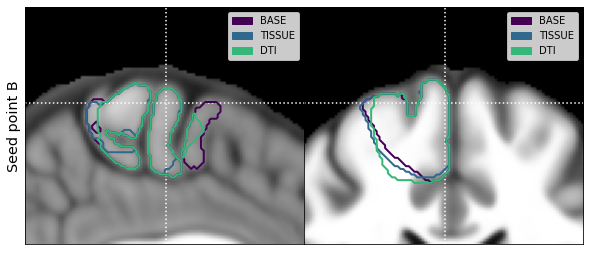

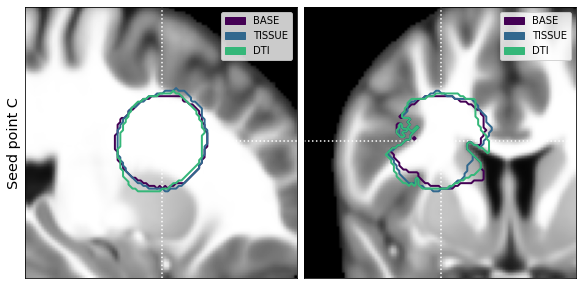

In [3]:
main_dir = '/path/to/dataset/here/simulations/'

parameter_dirs = [
    {
    'label': 'A',
    'x': 129,
    'y': 123,
    'z': 76,
    'DTI': os.path.join(main_dir, 'A_DTI'),
    'TISSUE': os.path.join(main_dir, 'A_TISSUE'),
    'BASE': os.path.join(main_dir, 'A_BASE')
    },
    {
    'label': 'B',
    'x': 147,
    'y': 110,
    'z': 87,
    'DTI': os.path.join(main_dir, 'B_DTI'),
    'TISSUE': os.path.join(main_dir, 'B_TISSUE'),
    'BASE': os.path.join(main_dir, 'B_BASE')
    },
    {
    'label': 'C',
    'x': 98,
    'y': 133,
    'z': 65,
    'DTI': os.path.join(main_dir, 'C_DTI'),
    'TISSUE': os.path.join(main_dir, 'C_TISSUE'),
    'BASE': os.path.join(main_dir, 'C_BASE')
    }
]

for i_loc, params in enumerate(parameter_dirs):
    ## z, y, x
    startpoint = (params['x'],params['y'],params['z'])
    atlas_path = '../resources/IITmean_t1.nii.gz'
    atlas_img = sitk.ReadImage(atlas_path)
    atlas_arr = sitk.GetArrayFromImage(atlas_img) 

    n = len(parameter_dirs)
    norm = mcolors.Normalize(vmin=0, vmax=n)
    colors = [cm.viridis(norm(i)) for i in range(n)]

    axs=None
    for reference_volume in [20*1000]:
        contours = []
        for i, (model, c) in enumerate(zip(['BASE', 'TISSUE', 'DTI'], colors)):
            tti_path = os.path.join(params[model], 'ranked_result.nii.gz')
            tti_img = sitk.ReadImage(tti_path)
            segim = get_seg_image_at_volume(tti_img, reference_volume)
            seg_array = sitk.GetArrayFromImage(segim)
            axs = plot_seg(atlas_arr, seg_array, startpoint, axs=axs, color=[c])

        proxy = [plt.Rectangle((0,0),1,1,color=c) for c in colors]
        axs[0].legend(proxy, list(['BASE', 'TISSUE', 'DTI']))
        axs[0].set_ylabel(f"Seed point {params['label']}", fontsize='x-large')
        axs[1].legend(proxy, list(['BASE', 'TISSUE', 'DTI']))
        plt.savefig(f'figures/growth_pattern_{i_loc}.jpg', bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.close()
        axs=None

TISSUE
DTI
TISSUE
DTI
TISSUE
DTI


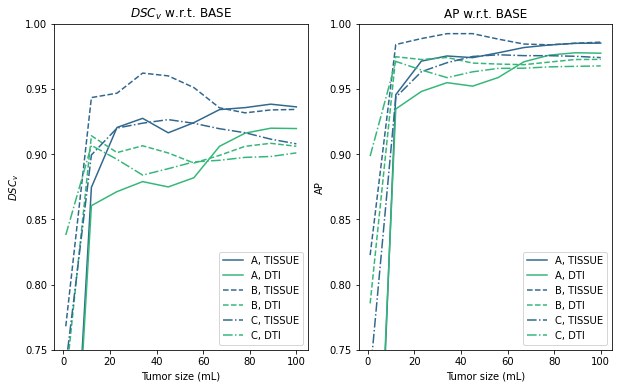

In [4]:
## compare in terms of error
volumes = np.linspace(1000,100000,10)
fig, axs = plt.subplots(1,2, figsize=(10,6))
name_ref = 'BASE'
linestyles = ['solid', 'dashed', 'dashdot']
for i_loc in range(len(parameter_dirs)):
    logdir_ref = parameter_dirs[i_loc][name_ref]
    point = parameter_dirs[i_loc]['label']
    tti_path = os.path.join(logdir_ref, 'ranked_result.nii.gz')
    tti_img = sitk.ReadImage(tti_path)
    tti_arr = sitk.GetArrayFromImage(tti_img)
    
    for name, c in zip(['TISSUE', 'DTI'], colors[1:]):
        logdir = parameter_dirs[i_loc][name]
        results_dsc = []
        results_ap = []
        print(name)
        tti_path = os.path.join(logdir, 'ranked_result.nii.gz')
        tti_img_dti = sitk.ReadImage(tti_path)
        tti_arr_dti = sitk.GetArrayFromImage(tti_img_dti)

        inclusion_mask = tti_arr_dti > 0
        values = 0 - tti_arr_dti[inclusion_mask]

        for reference_volume in volumes:
            segim = get_seg_image_at_volume(tti_img, reference_volume)
            seg_arr = sitk.GetArrayFromImage(segim)
            segim_dti = get_seg_image_at_volume(tti_img_dti, reference_volume)

            overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
            overlap_measures_filter.Execute(segim, segim_dti)
            results_dsc.append(overlap_measures_filter.GetDiceCoefficient())

            reference_values = seg_arr[inclusion_mask]
            AP = average_precision_score(reference_values, values)
            results_ap.append(AP)



        axs[1].plot(volumes/1000, results_ap, label=f'{point}, {name}', color=c, linestyle=linestyles[i_loc])
    # ax2 = ax1.twinx()
        axs[0].plot(volumes/1000, results_dsc, label=f'{point}, {name}', color=c, linestyle=linestyles[i_loc])
axs[0].legend()
axs[0].set_ylim([0.75, 1])
axs[0].set_ylabel(f'$DSC_v$')
axs[0].set_xlabel('Tumor size (mL)')
axs[0].set_title(f'$DSC_v$ w.r.t. {name_ref}')
axs[1].legend()
axs[1].set_ylim([0.75, 1])
axs[1].set_ylabel(f'AP')
axs[1].set_xlabel('Tumor size (mL)')
axs[1].set_title(f'AP w.r.t. {name_ref}')
plt.savefig('figures/metrics_simulation.jpg')
plt.show()
plt.close()

Plotting BASE for reference volume 20000
Selected t=900.0
Plotting TISSUE for reference volume 20000
Selected t=900.0
Plotting DTI for reference volume 20000
Selected t=900.0


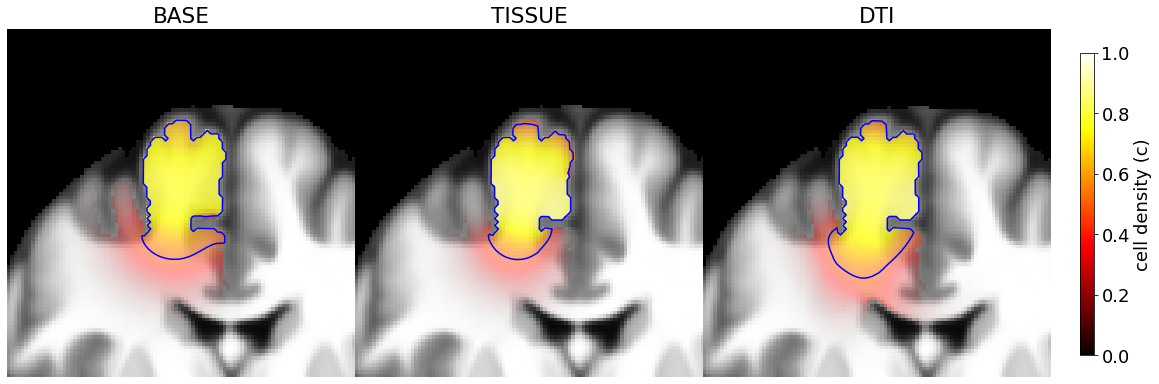

In [6]:
import matplotlib as mpl

plt.rcParams.update({'font.size': 18})

for reference_volume in [20*1000]:
    fig, axs = plt.subplots(1,3, figsize=(20,7))
    
    
    for name, c, ax in zip(['BASE', 'TISSUE', 'DTI'], colors, axs):
        print(f"Plotting {name} for reference volume {reference_volume}")
        
        params = parameter_dirs[0]
        logdir = params[name]
        startpoint = (params['x'], params['y'], params['z'])
        tti_path = os.path.join(logdir, 'ranked_result.nii.gz')
        tti_img = sitk.ReadImage(tti_path)
        tti_arr = sitk.GetArrayFromImage(tti_img)
        ## Get closest to reference volume
        sorted_indices = np.argsort(tti_arr, axis=None)
        selected_index = sorted_indices[int(reference_volume)]
        tti = np.ravel(tti_arr)[selected_index]
        im_path = os.path.join(logdir, f'result_t_{np.round(tti, -2)}.nii.gz')
        print(f"Selected t={np.round(tti, -2)}")
        res_im = sitk.ReadImage(im_path)
        res_arr = sitk.GetArrayFromImage(res_im)
        umap = res_arr[
            startpoint[0]-50:startpoint[0]+50,
            startpoint[1],
            startpoint[2]-50:startpoint[2]+50]
        background = atlas_arr[
            startpoint[0]-50:startpoint[0]+50,
            startpoint[1],
            startpoint[2]-50:startpoint[2]+50]
        
        alphamap = np.clip(umap, 0.0, 1.0)
        ax.imshow(background, cmap='gray')
        ax.imshow(umap, cmap='hot', vmin=0, vmax=1, alpha=alphamap)
        ax.contour(umap, levels=[0.5],colors=['b'])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.axis('off')
        ax.set_aspect('equal')

        ax.invert_yaxis()
        ax.set_title(name, size='large')
        
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, 0.2, 0.01, 0.6])
    cmap = mpl.cm.hot
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    cb1.set_label('cell density (c)')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('figures/cell_pattern.jpg', bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()


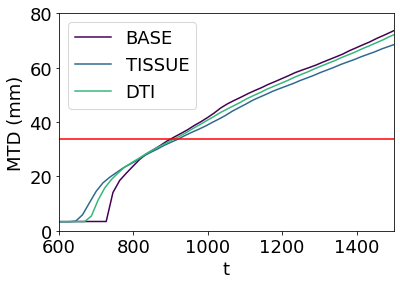

In [7]:
for name, c, ax in zip(['BASE', 'TISSUE', 'DTI'], colors, axs):
    
    params = parameter_dirs[0]
    tti_path = os.path.join(params[name], 'ranked_result.nii.gz')
    tti_img = sitk.ReadImage(tti_path)
    tti_arr = sitk.GetArrayFromImage(tti_img)
    
    tti_sel = tti_arr[tti_arr <2000]
    H,X1 = np.histogram(tti_sel, bins = 100)
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)
    diam_tmp = 3*F1/(4*np.pi)
    diameters = 2*np.cbrt(diam_tmp)
    plt.plot(X1[1:], diameters, label=name, color=c)
    
volume_limit = 2*np.cbrt(3*20000/(4*np.pi))
plt.axhline(y = volume_limit, color = 'r', linestyle = '-')
plt.legend()
plt.xlabel('t')
plt.ylabel('MTD (mm)')
plt.xlim(600, 1500)
plt.ylim(0, 80)
plt.savefig('figures/growth_speed.jpg')
plt.show()